<a href="https://colab.research.google.com/github/asikfarieth/fypproj/blob/main/DeepLearningFYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from skimage.color import rgb2gray


In [10]:
# Ensure kaggle.json is present
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Sep 25 03:53 kaggle.json


In [11]:
# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [12]:
# use the Kaggle API to download the dataset
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

100% 23.1G/23.1G [19:34<00:00, 24.4MB/s]
100% 23.1G/23.1G [19:34<00:00, 21.1MB/s]


In [13]:
# unzip the dataset
!unzip -q fashion-product-images-dataset.zip


In [14]:
# Set the data path to the current directory
data_path = "./fashion-dataset"


In [15]:
# Load the CSV file
df = pd.read_csv(os.path.join(data_path, 'styles.csv'), error_bad_lines=False)

# Sample a fraction of the dataset. For example, 10%:
df_sampled = df.sample(frac=0.10, random_state=42)


<ipython-input-15-a4330c8c183f>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(os.path.join(data_path, 'styles.csv'), error_bad_lines=False)
Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 

In [16]:
# Load image paths for the sampled dataset
image_paths = [os.path.join(data_path, "images", str(id) + ".jpg") for id in df_sampled['id']]


In [17]:
# Function to convert images to features using Histogram of Oriented Gradients (HOG)
def extract_features(image_path):
    try:
        image = Image.open(image_path).resize((128, 128))
        image = np.array(image)
        if len(image.shape) == 2:  # If the image is grayscale
            image = np.stack([image] * 3, axis=-1)
        gray_image = rgb2gray(image)
        hog_features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        return hog_features
    except:
        return None

# Extract HOG features
features = [extract_features(image_path) for image_path in image_paths]

# Remove failed extractions and corresponding rows
valid_indices = [i for i, feature in enumerate(features) if feature is not None]
features = [features[i] for i in valid_indices]
df_sampled = df_sampled.iloc[valid_indices]

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_sampled['articleType'])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [18]:
# Identify the unique classes in the sampled data
unique_classes = df_sampled['articleType'].unique()

# Filter the label encoder's classes
filtered_classes = [cls for cls in label_encoder.classes_ if cls in unique_classes]


In [19]:
# Combine y_train and y_test to get all unique labels
all_labels = np.concatenate([y_train, y_test])
unique_labels = np.unique(all_labels)

# Map unique labels to their string representation
class_names = label_encoder.inverse_transform(unique_labels)


In [20]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Directly get class names from the label encoder
class_names = label_encoder.classes_

# Compute unique labels in y_test and y_pred
actual_unique_labels = np.unique(np.concatenate([y_test, y_pred]))

# Print the classification report
print(classification_report(y_test, y_pred, labels=actual_unique_labels, target_names=class_names[actual_unique_labels]))


                           precision    recall  f1-score   support

       Accessory Gift Set       1.00      0.67      0.80         3
                Backpacks       0.64      0.90      0.75        10
                   Bangle       0.00      0.00      0.00         3
                Bath Robe       0.00      0.00      0.00         1
                    Belts       0.84      1.00      0.91        16
                      Bra       1.00      0.62      0.77         8
                 Bracelet       0.50      0.50      0.50         2
                   Briefs       0.71      0.91      0.80        11
                   Capris       0.00      0.00      0.00         3
                     Caps       0.86      0.60      0.71        10
             Casual Shoes       0.64      0.85      0.73        55
             Clothing Set       0.00      0.00      0.00         1
                 Clutches       1.00      0.25      0.40         4
                  Compact       1.00      0.50      0.67     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [21]:
# MLP Classifier

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Initialize the Multi-layer Perceptron Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=1e-4,
                    solver='adam', verbose=10, random_state=42,
                    learning_rate_init=.001)

# Train the model
mlp.fit(X_train, y_train)

# Predictions
y_pred = mlp.predict(X_test)

# Compute unique labels in y_test and y_pred
actual_unique_labels = np.unique(np.concatenate([y_test, y_pred]))

# Print the classification report
print(classification_report(y_test, y_pred, labels=actual_unique_labels, target_names=class_names[actual_unique_labels]))


Iteration 1, loss = 3.06435805
Iteration 2, loss = 1.73980413
Iteration 3, loss = 1.26024558
Iteration 4, loss = 0.97637976
Iteration 5, loss = 0.78751517
Iteration 6, loss = 0.64726616
Iteration 7, loss = 0.53419792
Iteration 8, loss = 0.44847968
Iteration 9, loss = 0.37725814
Iteration 10, loss = 0.32076492
Iteration 11, loss = 0.26846290
Iteration 12, loss = 0.22763464
Iteration 13, loss = 0.19485920
Iteration 14, loss = 0.17019159
Iteration 15, loss = 0.14690535
Iteration 16, loss = 0.12700037
Iteration 17, loss = 0.11075325
Iteration 18, loss = 0.09660903
Iteration 19, loss = 0.08509904
Iteration 20, loss = 0.07564874
Iteration 21, loss = 0.06799567
Iteration 22, loss = 0.06095271
Iteration 23, loss = 0.05487417
Iteration 24, loss = 0.05015279
Iteration 25, loss = 0.04556097
Iteration 26, loss = 0.04221081
Iteration 27, loss = 0.03878942
Iteration 28, loss = 0.03519757
Iteration 29, loss = 0.03249548
Iteration 30, loss = 0.02992231
Iteration 31, loss = 0.02774238
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [23]:
# Constructing the image path based on the 'id' column
df_sampled['image_path'] = df_sampled['id'].apply(lambda x: os.path.join(data_path, 'images', f'{x}.jpg'))


In [24]:
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Image loading and preprocessing function
def load_images(image_paths, target_size=(64, 64)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        images.append(img)
    return np.array(images) / 255.0  # Normalize

X = load_images(df_sampled['image_path'])
le = LabelEncoder()
y = le.fit_transform(df_sampled['subCategory'])
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


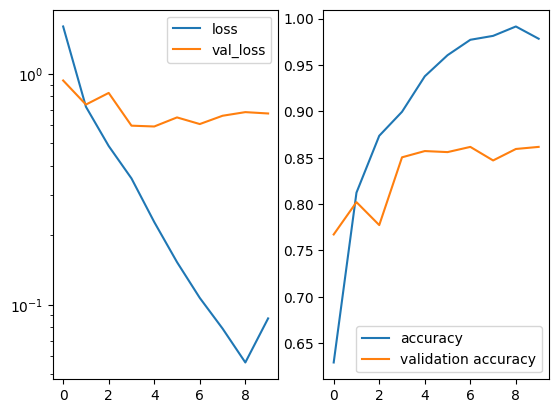

112/112 [==============================] - 1s 9ms/step - loss: 0.0874 - accuracy: 0.9783 - val_loss: 0.6744 - val_accuracy: 0.8616


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from IPython.display import clear_output


class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1

        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()

        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()

        plt.show();

plot = PlotLearning()

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))  # Number of unique subCategories

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[plot])


In [26]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001, verbose=1)

# Image loading and preprocessing function
def load_images(image_paths, target_size=(64, 64)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        images.append(img)
    return np.array(images) / 255.0  # Normalize

X = load_images(df_sampled['image_path'])
le = LabelEncoder()
y = le.fit_transform(df_sampled['subCategory'])
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming you've already defined the PlotLearning class above
plot = PlotLearning()


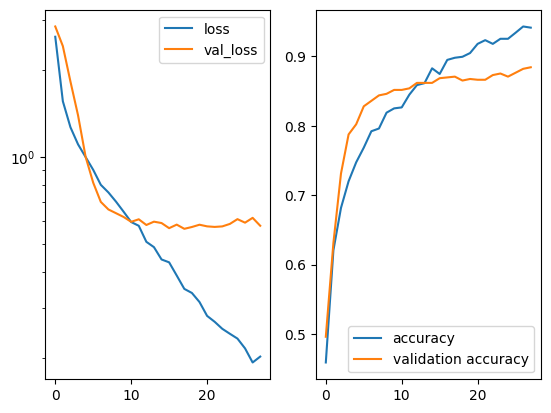

85/85 [==============================] - 1s 15ms/step - loss: 0.2030 - accuracy: 0.9412 - val_loss: 0.5774 - val_accuracy: 0.8841
Epoch 28: early stopping


In [27]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, Nadam
from IPython.display import clear_output
from keras.callbacks import EarlyStopping


num_classes = y_train.shape[1]  # Based on the to_categorical encoding
input_shape = (64, 64, 3)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.6))


# Flattening
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Define your learning rate
learning_rate = 0.00004

# Compile your model and specify the optimizer with the learning rate
model.compile(optimizer=Nadam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summarize the model structure
model.summary()

# Train the CNN model
history = model.fit(X_train, y_train, epochs=70, batch_size=42,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop, plot])
